# Seasonal plot
This notebooks plots the RMSE of the univariate TFT predictions over time showing large fluctuations in seasonality.

In [ ]:
import copy
from datetime import timedelta

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import pickle

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import EncoderNormalizer
from pytorch_forecasting.data import MultiNormalizer
from pytorch_forecasting.data import TorchNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Here we calculate the RMSE per univariate target and prediction length per month
df_total=pd.DataFrame()
# Load the result tensors
true_y_path = ['TFT/saved_predictions_univariate/true DE_solar_generation_actual24.pt','TFT/saved_predictions_univariate/true DE_solar_generation_actual48.pt',
               'TFT/saved_predictions_univariate/true DE_solar_generation_actual96.pt','TFT/saved_predictions_univariate/true DE_solar_generation_actual192.pt',
              'TFT/saved_predictions_univariate/true DE_wind_generation_actual24.pt','TFT/saved_predictions_univariate/true DE_wind_generation_actual48.pt',
               'TFT/saved_predictions_univariate/true DE_wind_generation_actual96.pt','TFT/saved_predictions_univariate/true DE_wind_generation_actual192.pt',
              'TFT/saved_predictions_univariate/true DE_load_actual_entsoe_transparency24.pt','TFT/saved_predictions_univariate/true DE_load_actual_entsoe_transparency48.pt',
               'TFT/saved_predictions_univariate/true DE_load_actual_entsoe_transparency96.pt','TFT/saved_predictions_univariate/true DE_load_actual_entsoe_transparency192.pt']
predictions_path = ['TFT/saved_predictions_univariate/predictions DE_solar_generation_actual24.pt','TFT/saved_predictions_univariate/predictions DE_solar_generation_actual48.pt',
               'TFT/saved_predictions_univariate/predictions DE_solar_generation_actual96.pt','TFT/saved_predictions_univariate/predictions DE_solar_generation_actual192.pt',
              'TFT/saved_predictions_univariate/predictions DE_wind_generation_actual24.pt','TFT/saved_predictions_univariate/predictions DE_wind_generation_actual48.pt',
               'TFT/saved_predictions_univariate/predictions DE_wind_generation_actual96.pt','TFT/saved_predictions_univariate/predictions DE_wind_generation_actual192.pt',
              'TFT/saved_predictions_univariate/predictions DE_load_actual_entsoe_transparency24.pt','TFT/saved_predictions_univariate/predictions DE_load_actual_entsoe_transparency48.pt',
               'TFT/saved_predictions_univariate/predictions DE_load_actual_entsoe_transparency96.pt','TFT/saved_predictions_univariate/predictions DE_load_actual_entsoe_transparency192.pt']

for true_y_path,predictions_path in zip(true_y_path,predictions_path):
    true_y = torch.load(true_y_path)
    predictions = torch.load(predictions_path)
    column_name = os.path.basename(true_y_path)
    true_y = true_y.numpy()
    true_y = np.squeeze(true_y, axis=1)
    predictions = predictions.numpy()
    predictions = np.squeeze(predictions, axis=1)
    # Specify column names
    column_names = ['true_y', 'predictions']

    # Create a Pandas DataFrame
    df = pd.DataFrame(data={column_names[0]: true_y, column_names[1]: predictions})

    # Manually set the start date of the test data set
    start_date = pd.to_datetime('2019-01-04 02:00:00')
    date_range = pd.date_range(start=start_date, periods=len(df), freq='H')

    # Set the date range as the index
    df.set_index(date_range, inplace=True)

    # Calculate RMSE per month
    monthly_rmse = []
    for month, group in df.groupby(df.index.month):
        rmse = np.sqrt(mean_squared_error(group['true_y'], group['predictions']))
        monthly_rmse.append({'rmse': rmse})

    # Create a new DataFrame with monthly RMSE
    monthly_rmse_df = pd.DataFrame(monthly_rmse)
    # Append as a column to df_total
    df_total[column_name] = monthly_rmse_df['rmse'].values

In [37]:
# Create a dictionary to map numerical values to month names
month_mapping = {
    0: 'Jan', 1: 'Feb', 2: 'Mar', 3: 'Apr', 4: 'May', 5: 'Jun',
    6: 'Jul', 7: 'Aug', 8: 'Sep', 9: 'Oct', 10: 'Nov', 11: 'Dec'
}

df_total.index = df_total.index.map(month_mapping)

In [38]:
df_total

,true DE_solar_generation_actual24.pt,true DE_solar_generation_actual48.pt,true DE_solar_generation_actual96.pt,true DE_solar_generation_actual192.pt,true DE_wind_generation_actual24.pt,true DE_wind_generation_actual48.pt,true DE_wind_generation_actual96.pt,true DE_wind_generation_actual192.pt,true DE_load_actual_entsoe_transparency24.pt,true DE_load_actual_entsoe_transparency48.pt,true DE_load_actual_entsoe_transparency96.pt,true DE_load_actual_entsoe_transparency192.pt
Jan,0.244728,0.226613,0.228184,0.266943,1.096106,1.395131,1.290580,1.497636,0.181307,0.163606,0.184534,0.227073
Feb,0.401808,0.424421,0.440010,0.405291,1.253859,1.525067,1.744251,1.472828,0.193584,0.212518,0.213303,0.259899
Mar,0.549271,0.510012,0.570918,0.577659,1.624123,1.818782,1.718425,2.178343,0.212058,0.241927,0.254285,0.256524
Apr,0.482134,0.474984,0.680833,0.579529,0.947773,1.018585,1.218859,1.307726,0.450552,0.470147,0.455607,0.449764
May,0.629983,0.550125,0.591140,0.596031,0.670384,0.903653,0.845284,0.972487,0.385904,0.369732,0.352823,0.450511
Jun,0.542722,0.559109,0.609374,0.717885,0.967820,0.956637,1.065742,1.103094,0.396392,0.416442,0.453697,0.412039
Jul,0.445497,0.476771,0.676203,0.679419,0.801037,0.935206,0.939829,0.994056,0.162639,0.166883,0.199928,0.214795
Aug,0.405604,0.439983,0.623331,0.499339,0.757413,0.875915,0.952956,1.032215,0.155034,0.177569,0.196161,0.219048
Sep,0.484146,0.514983,0.546043,0.459572,0.935002,1.157712,1.186158,1.307769,0.176792,0.225719,0.230148,0.231297
Oct,0.455254,0.330742,0.329223,0.357806,1.188055,1.400572,1.459416,1.588462,0.223544,0.299748,0.275715,0.287997


In [40]:
# Average the first four columns to get the values for solar, the next four for wind, and the next four for load
df_total = pd.DataFrame({
    'Average Monthly RMSE Solar': df_total.iloc[:, 0:4].mean(axis=1),
    'Average Monthly RMSE Wind': df_total.iloc[:, 4:8].mean(axis=1),
    'Average Monthly RMSE Load': df_total.iloc[:, 8:12].mean(axis=1),
}, index=df_total.index)

In [41]:
# Calculate the percentage variance
percentage_variance = (df_total.max() - df_total.min()) / df_total.min() * 100
print(percentage_variance)

Average Monthly RMSE Solar    151.336811
Average Monthly RMSE Wind     116.394031
Average Monthly RMSE Load     145.358788
dtype: float64


In [55]:
df_total_1=df_total.drop(['Average Monthly RMSE Solar','Average Monthly RMSE Load'], axis=1)
df_total_2=df_total.drop(['Average Monthly RMSE Wind'], axis=1)

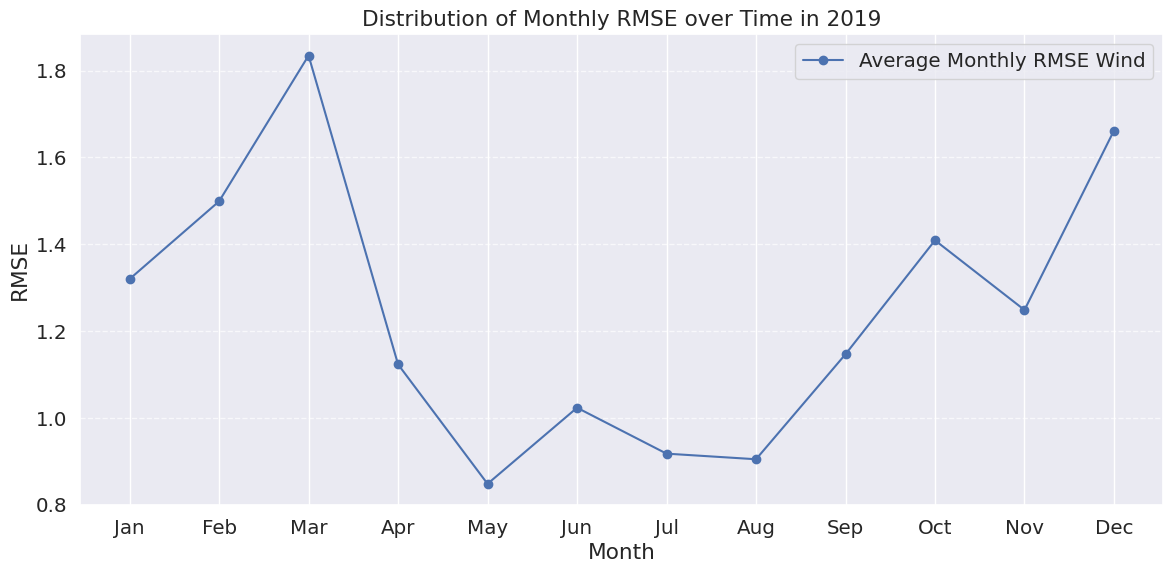

In [57]:
# Plot each RMSE column as a separate line
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.3)
for column in df_total_1.columns:
    plt.plot(df_total_1 .index, df_total_1[column], marker='o', linestyle='-', label=column)

plt.title('Distribution of Monthly RMSE over Time in 2019')
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.tight_layout()

plt.savefig('RMSE over Time Wind')
plt.show()

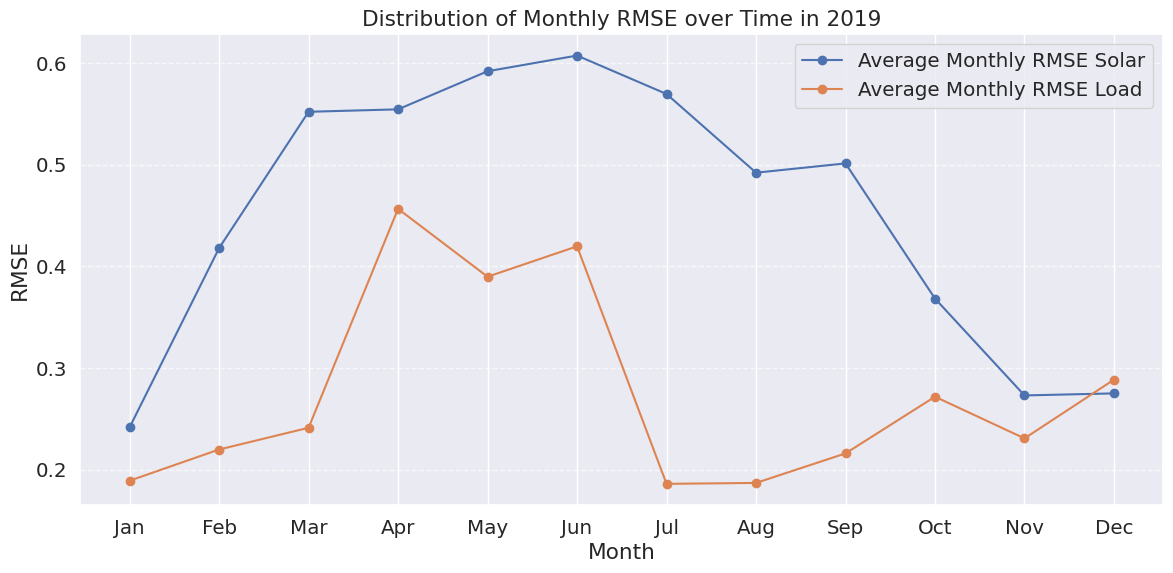

In [58]:
# Plot each RMSE column as a separate line
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.3)
# Loop over each column
for column in df_total_2.columns:
    plt.plot(df_total_2 .index, df_total_2[column], marker='o', linestyle='-', label=column)

plt.title('Distribution of Monthly RMSE over Time in 2019')
plt.xlabel('Month')
plt.ylabel('RMSE')
# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.tight_layout()

plt.savefig('RMSE over Time Load Solar')
plt.show()